# Imports: 

In [22]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [23]:
import sklearn
import xgboost

In [26]:
cols = sns.color_palette("tab10")

In [27]:
def plot_confusion_matrix(clf, confusion, category, counter, reg_param_temp, model, shuffle, version):
    
    col_names = list(clf.classes_)
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    plt.figure(figsize=(6,6))
    rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    sns.set(rc=rc)
    heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.1f', square=True, annot_kws={"fontsize":12})
    
    if shuffle:
        str_title = category+ '\n' + 'C = '+ str(reg_param_temp) + '\n' + model + ' shuffled data' 
    else:
        str_title = category+ '\n' + 'C = '+ str(reg_param_temp) + '\n' + model
    plt.title(str_title, fontsize = 12)
    plt.tight_layout()
    
    path_fig = '../figures/confusion_mats/'
    if shuffle:
        fn_fig = category.split()[0].split('/')[0]+'_C_'+str(counter)+'_'+model+'_SHUFFLE_'+version+'_.png'
    else: 
        fn_fig = category.split()[0].split('/')[0]+'_C_'+str(counter)+'_'+model+'_'+version+'_.png'
    
    file_fig = os.path.join(path_fig, fn_fig)
    plt.savefig(file_fig, dpi=250)

In [28]:
def classifier(X, df_lfc, list_categories, model, shuffle, version, plotting = False):

    n_splits = 5
    n_classes = 2
    list_accuracy = []
    list_log_loss = []
    list_roc_auc = []
    
    if model == 'logreg':
        reg_param_list = np.array([1e-2, 1e-1, 1e0]) # l1 regularization
    elif model == 'xgbc':
        reg_param_list = np.array([10, 100])
    
    for category in list_categories: # For each gene functional category
        print(category)
        # create y-vector of 0's (doesn't belong to category) and 1's (belongs to category)
        y = np.zeros(df_lfc.shape[0])
        ind_ones = [i for i in range(df_lfc.shape[0]) if df_lfc.iloc[i].Functional_Category == category]
        y[ind_ones] = 1
        
        # shuffle or don't shuffle y
        y_shfl = y.copy()
        if shuffle: 
            random.shuffle(y_shfl)
        else:
            y_shfl = y.copy() # you don't need this
        
        counter = 0 # used for figure filename, to know what reg. parameter was used. 
        for reg_param_temp in reg_param_list:   # For each regularization parameter: 
#             print("C = ", reg_param_temp)
            accuracy = [] # stores accuracy in each fold
            log_loss_var = [] # stores log-loss in each fold
            roc_auc = []
            confusion = np.zeros((n_classes, n_classes)) # initialize confusion matrix. 
    
            if model == 'logreg':
                clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
    #             clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
            elif model == 'xgbc':
                clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1, eval_metric='logloss', use_label_encoder=False)
            elif model == 'forest':
                clf=RandomForestClassifier(n_estimators=100)

            skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y_shfl[train_index], y_shfl[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
                # fit model
                clf.fit(X_train, y_train)
                # predict on test set
                y_hat = clf.predict(X_test)
                # compute: confusion matrix, accuracy, log-loss
                confusion += confusion_matrix(y_test, y_hat)
                accuracy.append(accuracy_score(y_test, y_hat))        
                y_pred = clf.predict_proba(X_test)
                
                # update prediction probabilities matrix
                log_loss_var.append(log_loss(y_test, y_pred))
                roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

            # normalize confusion matrix
            confusion = normalize(confusion, axis=1, norm='l1') 
            list_accuracy.append( np.median(accuracy) )
            list_log_loss.append( np.median(log_loss_var) ) 
            list_roc_auc.append( np.median(roc_auc) )
            
            # Plotting: 
            if plotting:
                plot_confusion_matrix(clf, confusion, category, counter, reg_param_temp, model, shuffle, version)

            counter += 1
            
    df_accuracy = pd.DataFrame()
    ll_categories_temp = [len(reg_param_list)*[l] for l in list_categories]
    ll_categories = [item for sublist in ll_categories_temp for item in sublist]
    df_accuracy['category'] = ll_categories
    df_accuracy['C_reg'] = len(list_categories)*list(reg_param_list)
    df_accuracy['accuracy'] = list_accuracy
    df_accuracy['log_loss'] = list_log_loss
    df_accuracy['roc_auc'] = list_roc_auc


    return df_accuracy, confusion

# Load data:

##### See make_data.ipynb

In [29]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'


In [30]:
if version == 'old':
    fn = 'lfc_mb_filt_OLD.csv' ## data set without Claire's screens
elif version == 'clare_all':
    fn = 'lfc_mb_filt.csv' ## data set with all of Claire's pairwise combinations
elif version == 'clare_basis':
    fn = 'lfc_mb_filt_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/cleaned_ML/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.shape

(2937, 127)

### Get X matrix (TnSeq screens) and functional categories  

In [31]:
df_lfc[df_lfc.Functional_Category == 'information pathways' ].head(3).Rv_ID

0    Rv0001
1    Rv0002
2    Rv0003
Name: Rv_ID, dtype: object

In [32]:
cols_data = df_lfc.columns[1:-1]
X = df_lfc[cols_data].to_numpy()
print(X.shape)

list_categories = df_lfc.Functional_Category.unique().tolist()
list_categories

(2937, 125)


['information pathways',
 'cell wall and cell processes',
 'intermediary metabolism and respiration',
 'regulatory proteins',
 'virulence, detoxification, adaptation',
 'insertion seqs and phages',
 'lipid metabolism',
 'PE/PPE']

In [33]:
df_lfc.columns

Index(['Rv_ID', 'PE35_KO_vs_mbio_H37Rv', 'PPE68_KO_vs_mbio_H37Rv',
       'Rv0950c_KO_vs_CB_WT', 'Rv0954_KO_vs_RJ_WT', 'Rv1096_KO_vs_CB_WT',
       'Rv3005c_KO_day32_vs_dejesus_H37Rv_day32',
       'Rv3594_KO_vs_Rubin_FLUTE_WT', 'Rv3684_KO_vs_CB_WT',
       'Rv3717_KO_vs_Rubin_FLUTE_WT',
       ...
       'IFNG_vs_C57BL.6J', 'NOD.ShiLtJ_vs_C57BL.6J', 'NOS_vs_C57BL.6J',
       'NZO.H1LtJ_vs_C57BL.6J', 'PWK.PhJ_vs_C57BL.6J', 'Phox_vs_C57BL.6J',
       'Rag_vs_C57BL.6J', 'Wsb.Eij_vs_C57BL.6J', 'in_vitro_vs_C57BL.6J',
       'Functional_Category'],
      dtype='object', length=127)

## Train classification model and evaluate accuracy: 

In [45]:
model = 'logreg'
# model = 'forest'
# model = 'xgbc'
plot_param = False

# true accuracies:
shuffle = False 
df_accuracy, confusion = classifier(X, df_lfc, list_categories, model, shuffle, version, plot_param)

information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages
lipid metabolism
PE/PPE


In [47]:
df_accuracy[df_accuracy.C_reg==0.1]

,category,C_reg,accuracy,log_loss,roc_auc
1,information pathways,0.1,0.662692,0.630259,0.657415
4,cell wall and cell processes,0.1,0.561224,0.687002,0.568234
7,intermediary metabolism and respiration,0.1,0.565588,0.670958,0.608103
10,regulatory proteins,0.1,0.672913,0.647171,0.572104
13,"virulence, detoxification, adaptation",0.1,0.652470,0.648069,0.604658
16,insertion seqs and phages,0.1,0.850085,0.415253,0.775584
19,lipid metabolism,0.1,0.591141,0.675143,0.542100
22,PE/PPE,0.1,0.759796,0.500398,0.811261


In [48]:
path_data = 'results/'
fn_true = 'true_ll_roc_'+model+'_'+version+'.csv'
df_accuracy.to_csv(os.path.join(path_data, fn_true), index=False)

In [49]:
# shuffled y-vector accuracies: 
shuffle = True 
num_iter = 10
list_df_accuracy_SHFL = []
for ii in range(num_iter):
    print(ii, 'out of', num_iter)
    df_accuracy_SHFL, confusion_SHFL = classifier(X, df_lfc, list_categories, model, shuffle, version, plot_param)
    list_df_accuracy_SHFL.append(df_accuracy_SHFL)

# fn_shfl = 'shuffled_logloss_'+model+'_'+version+'.csv'
# df_accuracy_SHFL.to_csv(os.path.join(path_data, fn_shfl), index=False)

0 out of 10
information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages
lipid metabolism
PE/PPE
1 out of 10
information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages
lipid metabolism
PE/PPE
2 out of 10
information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages
lipid metabolism
PE/PPE
3 out of 10
information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages
lipid metabolism
PE/PPE
4 out of 10
information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation


## Compare accuracies of real vs. shuffled dataset: 

Read in dataframes (if necessary)

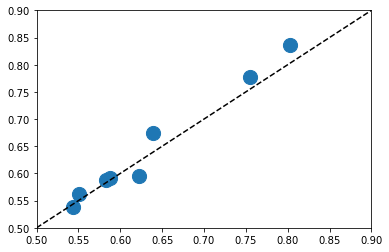

In [348]:
# df_accuracy_OLD = df_accuracy[df_accuracy.C_reg == 0.1].copy()

# # # version = 'old'
# version = 'clare_basis'
# # # version = 'clare_all'

# path_data = 'results/'
# fn_true = 'true_ll_roc_'+model+'_'+version+'.csv'
# # fn_shfl = 'shuffled_logloss_'+model+'_'+version+'.csv'
# df_accuracy = pd.read_csv(os.path.join(path_data, fn_true))
# # df_accuracy_SHFL = pd.read_csv(os.path.join(path_data, fn_shfl))

# df_accuracy_CB = df_accuracy[df_accuracy.C_reg == 0.1].copy()

# plt.scatter(df_accuracy_OLD.roc_auc, df_accuracy_CB.roc_auc, s = 200)
# xymin = 0.5
# xymax = 0.9
# xyline = np.linspace(xymin, xymax, 100)
# plt.xlim(xymin, xymax)
# plt.ylim(xymin, xymax)
# plt.plot(xyline, xyline, 'k--')

In [50]:
def plot_real_vs_shuffled_metric(df_accuracy, list_df_accuracy_SHFL, C, metric, model, topN_num = 2, xymin = 0.35, xymax = 0.85):

    metric_true = df_accuracy[df_accuracy.C_reg==C][metric].values
    list_metric_shfl = [ df[df.C_reg == C][metric].values for df in list_df_accuracy_SHFL ]
    # error bars: 
    metric_shfl_pc95 = np.array([np.percentile([ll[i] for ll in list_metric_shfl], 95) for i in range(len(list_metric_shfl[0]))])
    metric_shfl_pc5 = np.array([np.percentile([ll[i] for ll in list_metric_shfl], 5) for i in range(len(list_metric_shfl[0]))])
    metric_shfl_mean = np.array([np.median([ll[i] for ll in list_metric_shfl]) for i in range(len(list_metric_shfl[0]))])

    plt.figure(figsize=(7,7))
    plt.scatter(metric_true, metric_shfl_mean, color = cols[-3], s=100, edgecolors='k', linewidths=2)
    plt.errorbar(metric_true, metric_shfl_mean, yerr = [metric_shfl_mean-metric_shfl_pc5, metric_shfl_pc95-metric_shfl_mean], 
                 fmt = '.', markersize=1, capsize=5, ecolor='k')

    topN = df_accuracy[df_accuracy.C_reg==C].sort_values(by='log_loss').head(topN_num).category.tolist()

    for ii in range(len(topN)):
        cat = topN[ii]
        metric_true = df_accuracy[(df_accuracy.C_reg==C) & (df_accuracy.category==cat)][metric].values
        metric_shfl = np.median([ df[(df.C_reg == C) & (df.category==cat)][metric].values for df in list_df_accuracy_SHFL ])
        plt.scatter(metric_true, metric_shfl, color = cols[ii], s=200, edgecolors='k', linewidths=2)

    plt.legend(['other categories']+topN, fontsize = 16)
    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    if metric == 'roc_auc':
        plt.xlabel('classification score (ROC)', fontsize = 22)
        plt.ylabel('classification score (ROC)\nrandomized', fontsize = 22)
    elif metric == 'log_loss':
        plt.xlabel('classification score (cross entropy)', fontsize = 22)
        plt.ylabel('classification score (cross entropy)\nrandomized', fontsize = 22)
    xt = plt.xticks(fontsize = 14)
    yt = plt.yticks(fontsize = 14)
    plt.tight_layout()
    # save to file: 
    path_fig = '../figures/Adrian_classification/'
    fn_fig = 'true_vs_shuffle_'+metric+'_'+model+'_C_'+str(C)+'_'+version+'.png'
    plt.savefig(os.path.join(path_fig, fn_fig), dpi = 250)

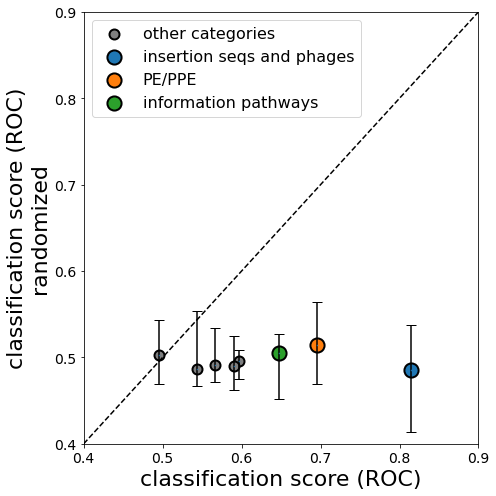

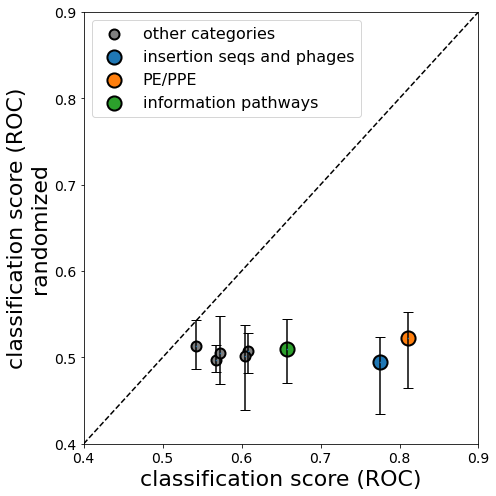

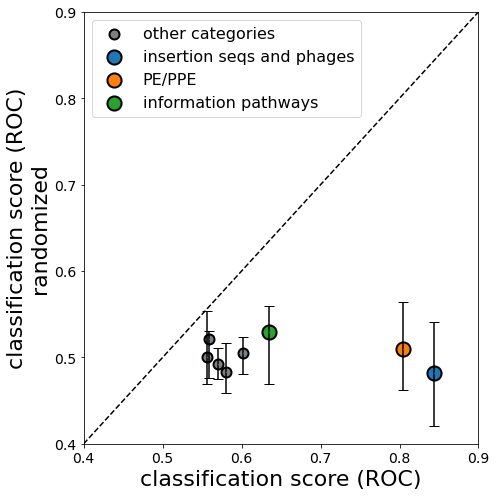

In [52]:
metric = 'roc_auc'
model = 'logreg' # log_reg
for C in df_accuracy.C_reg.unique():
    plot_real_vs_shuffled_metric(df_accuracy, list_df_accuracy_SHFL, C, metric, model, topN_num = 3, xymin = 0.4, xymax = 0.9)

# Effect of true positive fraction vs. shuffled data metric:

In [295]:
def rand_metric_vs_ntrue(df_lfc, model, reg_param_temp, n_true):

    n_classes = 2
    n_splits = 5

    n_total = df_lfc.shape[0]

    y = np.zeros(n_total)
    ind_true = np.random.choice(np.arange(len(y)), n_true, replace=False)
    y[ind_true]=1

    log_loss_var = [] # stores log-loss in each fold
    roc_auc = []

    if model == 'logreg':
        clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
    #     clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
    elif model == 'xgbc':
        clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
        # fit model
        clf.fit(X_train, y_train)
        # predict on test set
        y_hat = clf.predict(X_test)
        # compute: log-loss, roc_auc
        y_pred = clf.predict_proba(X_test)
        log_loss_var.append(log_loss(y_test, y_pred))
        roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

    return np.median(log_loss_var), np.median(roc_auc)


In [316]:
model = 'logreg'
if model == 'logreg':
    reg_param_temp = 1e-1 # l1 regularization
elif model == 'xgbc':
    reg_param_temp = 100
    
list_n_true = list(range(10, 500, 10)) + list(range(500, 1000, 50)) 
list_logloss = []
list_roc_auc = []

n_iter = 10

for n_true in list_n_true:
    print(n_true, 'out of', np.max(list_n_true))
    logloss_n_iter = []
    roc_auc_n_iter = []
    for ii in range(n_iter):
        logloss, roc_auc = rand_metric_vs_ntrue(df_lfc, model, reg_param_temp, n_true)
        logloss_n_iter.append(logloss)
        roc_auc_n_iter.append(roc_auc)
    list_logloss.append(np.median(logloss_n_iter))
    list_roc_auc.append(np.median(roc_auc_n_iter))

10 out of 950
20 out of 950
30 out of 950
40 out of 950
50 out of 950
60 out of 950
70 out of 950
80 out of 950
90 out of 950
100 out of 950
110 out of 950
120 out of 950
130 out of 950
140 out of 950
150 out of 950
160 out of 950
170 out of 950
180 out of 950
190 out of 950
200 out of 950
210 out of 950
220 out of 950
230 out of 950
240 out of 950
250 out of 950
260 out of 950
270 out of 950
280 out of 950
290 out of 950
300 out of 950
310 out of 950
320 out of 950
330 out of 950
340 out of 950
350 out of 950
360 out of 950
370 out of 950
380 out of 950
390 out of 950
400 out of 950
410 out of 950
420 out of 950
430 out of 950
440 out of 950
450 out of 950
460 out of 950
470 out of 950
480 out of 950
490 out of 950
500 out of 950
550 out of 950
600 out of 950
650 out of 950
700 out of 950
750 out of 950
800 out of 950
850 out of 950
900 out of 950
950 out of 950


In [317]:
reg_param_temp = 0.1

In [329]:
version = 'clare_basis'
# version = 'clare_all'

path_data = 'results/'
fn_true = 'true_ll_roc_'+model+'_'+version+'.csv'
df_accuracy = pd.read_csv(os.path.join(path_data, fn_true))
df_accuracy_C = df_accuracy[df_accuracy.C_reg == reg_param_temp].copy()

df_counts = pd.DataFrame()
df_counts['category'] = df_lfc['Functional_Category'].value_counts().keys()
df_counts['num_true_positive'] = df_lfc['Functional_Category'].value_counts().values

df_accuracy_numT = df_accuracy_C.merge(df_counts, on='category', how = 'inner')
df_accuracy_numT.sort_values(by = 'num_true_positive', ascending=False, inplace=True)
df_accuracy_numT

,category,C_reg,accuracy,log_loss,roc_auc,num_true_positive
2,intermediary metabolism and respiration,0.1,0.565588,0.673904,0.595045,933
1,cell wall and cell processes,0.1,0.578231,0.680395,0.588525,771
6,lipid metabolism,0.1,0.604770,0.656714,0.539048,270
0,information pathways,0.1,0.664395,0.634198,0.674126,242
4,"virulence, detoxification, adaptation",0.1,0.666099,0.647297,0.590825,220
3,regulatory proteins,0.1,0.667802,0.652431,0.562371,197
7,PE/PPE,0.1,0.768313,0.516668,0.777396,162
5,insertion seqs and phages,0.1,0.836735,0.411258,0.836839,142


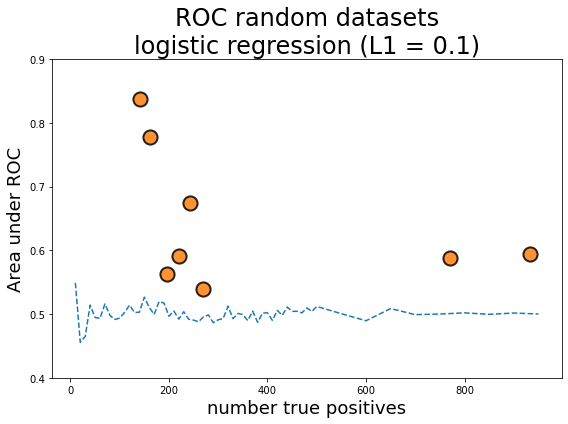

In [333]:
plt.figure(figsize=(8,6))
plt.plot(list_n_true, list_roc_auc, '--')
for index, row in df_accuracy_numT.iterrows():
    plt.scatter(row.num_true_positive, row.roc_auc, s=200, edgecolors='k', linewidths=2, color=cols[1], alpha =0.85)
plt.xlabel('number true positives', fontsize=18)
plt.ylabel('Area under ROC', fontsize=18)
plt.ylim(0.4, 0.9)
ttl = plt.title('ROC random datasets\nlogistic regression (L1 = 0.1)', fontsize = 24)
plt.tight_layout()
path_fig = '../figures/Adrian_classification/'
fn = 'ROC_random_logistic_C0.1.png'
plt.savefig(os.path.join(path_fig, fn), dpi=250)

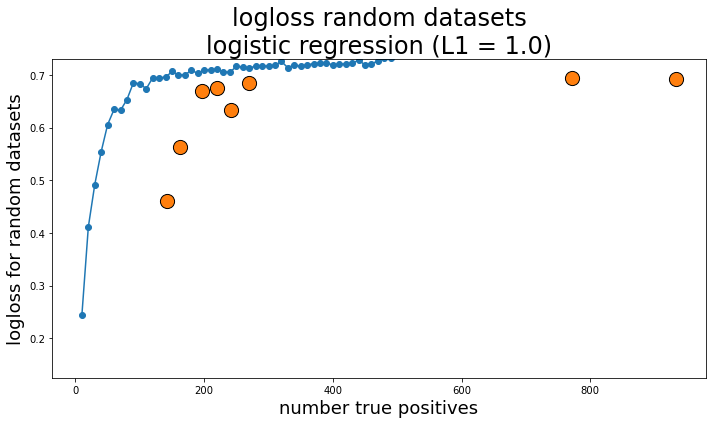

In [247]:
plt.figure(figsize=(10,6))
plt.plot(list_n_true, list_logloss, '-o')
plt.scatter(df_accuracy_numT.num_true_positive, df_accuracy_numT.log_loss, s=200, edgecolors='k', color=cols[1])
plt.xlabel('number true positives', fontsize=18)
plt.ylabel('logloss for random datasets', fontsize=18)
plt.ylim(0.125, 0.73)
ttl = plt.title('logloss random datasets\nlogistic regression (L1 = 1.0)', fontsize = 24)
plt.tight_layout()
path_fig = '../figures/Adrian_classification/'
fn = 'logloss_random_logistic_C1.0.png'
plt.savefig(os.path.join(path_fig, fn), dpi=250)

# OTHER: 

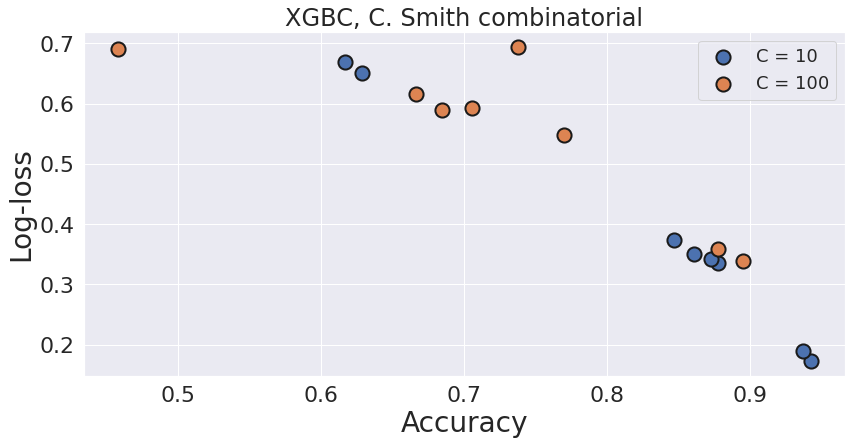

In [54]:
plt.figure(figsize=(12,6))
list_C = df_accuracy.C_reg.unique()
for C in list_C:
    df_temp = df_accuracy[df_accuracy.C_reg == C]
    plt.scatter(df_temp.accuracy, df_temp.log_loss, s=200, edgecolors='k', linewidths=2)
plt.legend(["C = "+str(c) for c in list_C], fontsize = 18)
plt.xlabel('Accuracy', fontsize = 28)
plt.ylabel('Log-loss', fontsize = 28)
# plt.xlim(0, 1)
# plt.ylim(0,1)
plt.tight_layout()
path_fig = '../figures'

plt.title('XGBC, C. Smith combinatorial', fontsize = 24)
file_fig = os.path.join(path_fig, 'scatter_xgbc_all.png')
plt.savefig(file_fig, dpi=250)

# multi-class predictor: 

In [19]:
y = df_lfc.Functional_Category.values
n_classes = df_lfc['Functional_Category'].nunique()

In [21]:
n_classes

8

Regularization parameter: 0.001
Starting cross validation:
computing and plotting accuracy:
Regularization parameter: 0.01
Starting cross validation:
computing and plotting accuracy:
Regularization parameter: 0.1
Starting cross validation:
computing and plotting accuracy:
Regularization parameter: 1.0
Starting cross validation:
computing and plotting accuracy:


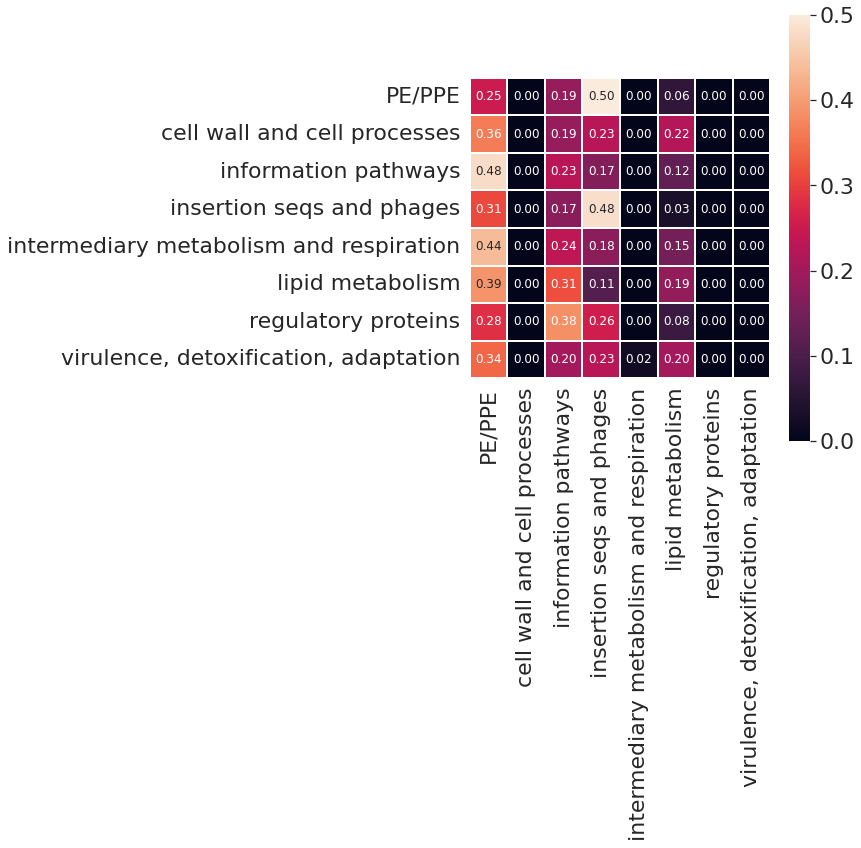

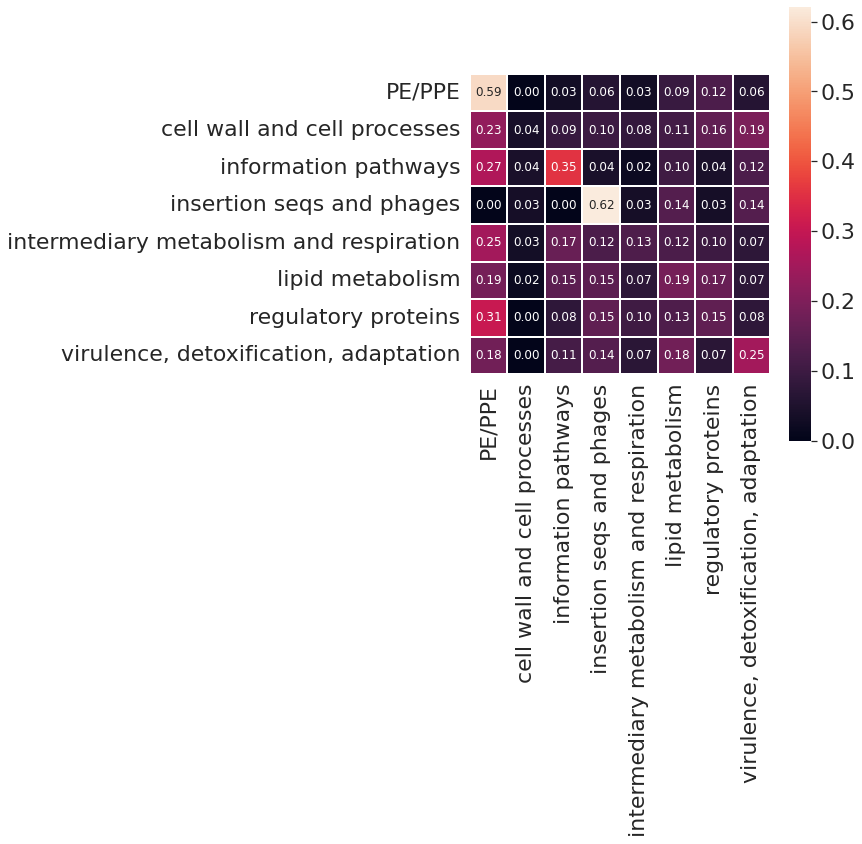

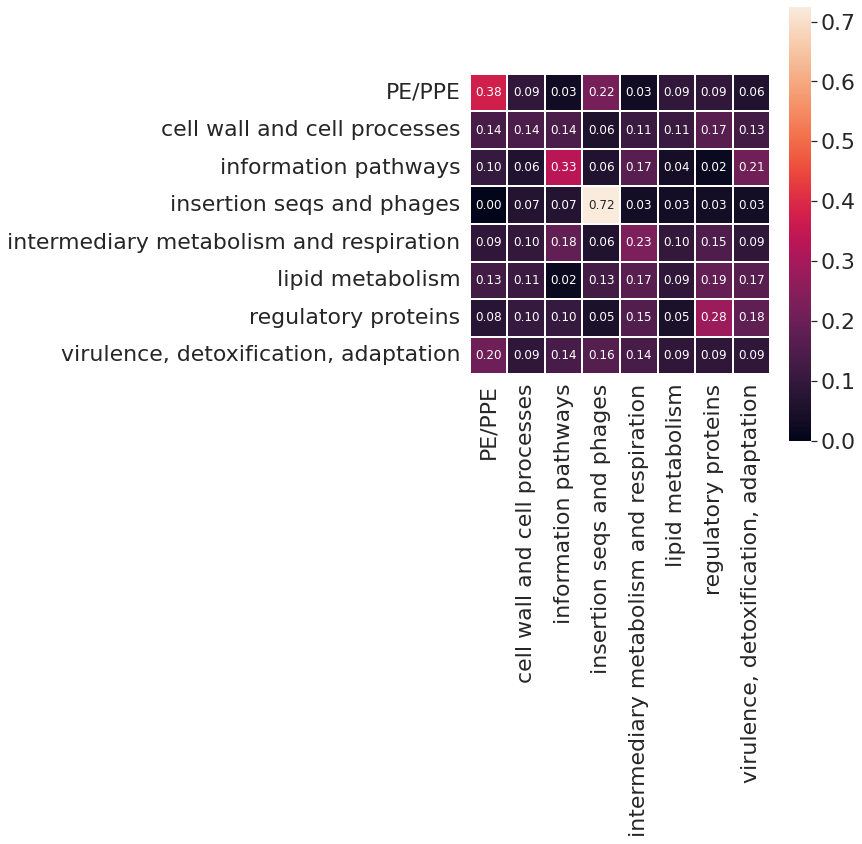

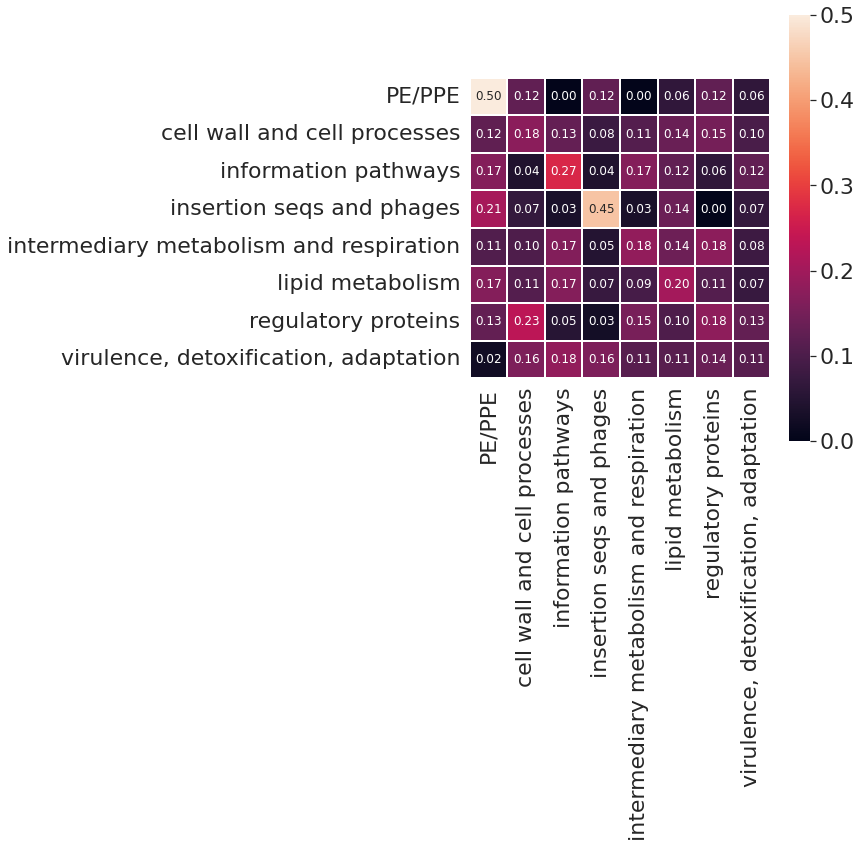

In [38]:
# reg_param_list = np.array([0.1, 0.2, 0.4, 0.6, 0.9])
reg_param_list = np.array([1e-3, 1e-2, 1e-1, 1e0])
n_splits = 5

list_accuracy = []
list_log_loss = []

for reg_param_temp in reg_param_list:

    print('Regularization parameter:', reg_param_temp)
    accuracy = []
    log_loss_var = []
    confusion = np.zeros((n_classes, n_classes))

#     clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    print('Starting cross validation:')
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
        clf.fit(X_train, y_train)

    y_hat = clf.predict(X_test)
    confusion += confusion_matrix(y_test, y_hat)
    # compute accuracy
    accuracy.append(accuracy_score(y_test, y_hat))        
    # compute log-loss
    y_pred = clf.predict_proba(X_test)
    log_loss_var.append(log_loss(y_test, y_pred))

    print('computing and plotting accuracy:')
    confusion = normalize(confusion, axis=1, norm='l1') # understand this step. 
    list_accuracy.append( np.median(accuracy) )
    list_log_loss.append( np.median(log_loss_var) )

    col_names = list(clf.classes_)
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    plt.figure(figsize=(12,12))
    rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    sns.set(rc=rc)reg_param_temp
    heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":12})
    # txt = heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS')

    plt.tight_layout()
